<h1 style="text-align: center;"><strong><span style="color: #ff0000;">Spark Performance Analysis and Tuning Guide</span></strong></h1>

# How Can A Spark Application Be Run?

<p>While Spark is design to work over a cluster, it is also capable to run on the following mode:<br /><br />(1) Local (client) mode:<br />(2) The Spark Standalone scheduler<br />(3) A Mesos cluster manager<br />(4) A YARN cluster<br />(5) Amazon EC2<br /><br />Since only the first two choices are relavant to our server, I will not go into details about Mesos,YARN and EC2. Note that, while local mode and standalone mode are both capable to run on a single node (machine), they are conceptually different.</p>

# Local mode

<p>The driver and the worker not only are on the same machine, but running in the same Java process.&nbsp; You can specify to run on a single core, specify a number of cores, or request to run on as many cores as the machine has.<br /><br /><strong>How:</strong><br />Firstly, set Spark_Home to '/usr/local/share/spark-2.0.1-bin-hadoop2.7/', either by bash (export SPARK_HOME=~/Desktop/spark-1.6.0-bin-hadoop2.6) or in code (os.environ['SPARK_HOME'] = '/usr/local/share/spark-2.0.1-bin-hadoop2.7/').</p>
<p>Then do:<br /><br /><span style="color: #0000ff;">from pyspark import SparkContext, SparkConf</span><br /><span style="color: #0000ff;">conf = SparkConf().setAppName('pubmed_open_access').setMaster('local[8]')</span><br /><span style="color: #0000ff;">sc = SparkContext(conf=conf)</span><br /><br />now you have a spark context that run in a JVM of 8 cores</p>

I will be testing the performance on 74 gz files. Each file is roughly 125 mb compressed or 500 mb uncompressed. The operation here involves a series of flat map and count. 

In [1]:
## Notebook property setup.

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import udf, col, lit, monotonically_increasing_id, explode
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.param import Param, Params
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler

import sys
import os
import time
from datetime import datetime
import datetime
import os.path
import json
from operator import add
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Helper function to keep track the run time of a spark ops.

def getTime(start):
    sec = time.time() - start
    m, s = divmod(sec, 60)
    h, m = divmod(m, 60)
    print('Spark operation takes - %d:%02d:%02d which is %d seconds in total' % (h,m,s,sec))
    

## Enable inline graphs
%matplotlib inline

## Display precision for pandas dataframe
pd.set_option('precision',10)

In [ ]:
if 'SPARK_HOME' not in os.environ:
    os.environ['SPARK_HOME'] = '/usr/local/share/spark-2.0.1-bin-hadoop2.7/'
    
num_cores = [1, 2, 10, 20, 40, 100, 172, 500]
run_time = []

In [ ]:
for i in num_cores:
    conf = SparkConf().setAppName('Performance_Testing_'+str(i)).setMaster('local['+str(i)+']')
    sc = SparkContext(conf=conf)

    data_raw = sc.textFile('/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Tweet_Output/Sample_Eng/')
    data = data_raw.map(lambda line: json.loads(line))
    sqlContext = SQLContext(sc)
    ## Define Dataframe schema.
    schema = StructType([StructField('creat_time', DoubleType(), False),
                         StructField('from_id', IntegerType(), False),
                         StructField('from_user', StringType(), False),
                         StructField('hashtag', StringType(), True),
                         StructField('location', StringType(), True),
                         StructField('mention', StringType(), True),
                         StructField('term', StringType(), True),
                         StructField('tweet_id', StringType(), False)                     
                        ])
    df = sqlContext.createDataFrame(data, schema)

    term_tokenizer = Tokenizer(inputCol="term", outputCol="words")
    term_remover = StopWordsRemover(inputCol=term_tokenizer.getOutputCol(), outputCol="filtered")
    term_cv = CountVectorizer(inputCol=term_remover.getOutputCol(), outputCol="term_features", minTF= 200, minDF=1)

    hashtag_tokenizer = Tokenizer(inputCol="hashtag", outputCol="tags")
    hashtag_cv = CountVectorizer(inputCol=hashtag_tokenizer.getOutputCol(), outputCol="hashtag_features", minTF = 250, minDF=1)

    mention_tokenizer = Tokenizer(inputCol="mention", outputCol="mentions")
    mention_cv = CountVectorizer(inputCol=mention_tokenizer.getOutputCol(), outputCol="mention_features", minTF= 250, minDF=1)

    user_tokenizer = Tokenizer(inputCol="from_user", outputCol="users")
    user_cv = CountVectorizer(inputCol=user_tokenizer.getOutputCol(), outputCol="user_features", minTF= 250, minDF=1)

    loc_tokenizer = Tokenizer(inputCol="location", outputCol="locs")
    loc_cv = CountVectorizer(inputCol=loc_tokenizer.getOutputCol(), outputCol="loc_features", minTF= 200, minDF=1)

    pipeline = Pipeline(stages=[term_tokenizer,term_remover,term_cv,hashtag_tokenizer,hashtag_cv,mention_tokenizer, \
                                mention_cv,user_tokenizer, user_cv, loc_tokenizer, loc_cv])

    loading = time.time()

    model = pipeline.fit(df)
    Train_X = model.transform(df)

    sec = time.time() - loading
    run_time.append(sec)
    SparkContext.stop(sc)

In [7]:
print(run_time)

[23666.322341918945, 12233.755597114563, 3154.57373213768, 2271.643699169159, 2021.8914141654968, 2025.3893520832062, 2010.4880039691925, 2022.0559360980988]


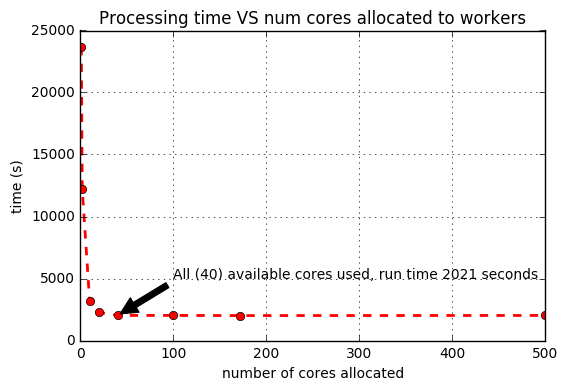

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(num_cores,run_time , lw=2, marker='o', linestyle='--', color='r', label='Square')

ax.annotate('All (40) available cores used, run time 2021 seconds', xy=(40, 2025), xytext=(100,5000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.xlabel('number of cores allocated')
plt.ylabel('time (s)')
plt.title('Processing time VS num cores allocated to workers')
plt.grid(True)


plt.show()

Intuively, with a single jvm process, the more cores we allocated to it, the faster it run.

# Standalone Mode

Now let's explore the standalone mode. In this set up, each worker is in a separate JVM. Note that the worker core and memory setup must be past before starting the master node by changing the spark-env.sh file; there is no easy way to set it at the code level (need to do some tricy bash command, not safe). Therefore, the run time is manually recorded after each run.

<p>The key difference here is that we can start multiple workers, each one has a dedicated amount of cores and memory. <br />In distributed mode, among <strong>N</strong> <em>worker nodes</em>, each node has <strong>M</strong> <em>executors</em> (usually equal to the number of CUP cores within each node). This is hold in single machine setup too (in theory...) when running Yarn or meose. However,the standalone scheduler does not allow multiple executor per worker node. (Apache claim this will added since 1.4, but it is still not available yet.) We must start<strong> N*M</strong> workers in order to get the same number of executors.</p> 

In [2]:
data_raw = sc.textFile('/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Tweet_Output/Sample_Eng/')
data = data_raw.map(lambda line: json.loads(line))
#sqlContext = SQLContext(sc)
## Define Dataframe schema.
schema = StructType([StructField('creat_time', DoubleType(), False),
                     StructField('from_id', IntegerType(), False),
                     StructField('from_user', StringType(), False),
                     StructField('hashtag', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('mention', StringType(), True),
                     StructField('term', StringType(), True),
                     StructField('tweet_id', StringType(), False)                     
                    ])
df = sqlContext.createDataFrame(data, schema)

term_tokenizer = Tokenizer(inputCol="term", outputCol="words")
term_remover = StopWordsRemover(inputCol=term_tokenizer.getOutputCol(), outputCol="filtered")
term_cv = CountVectorizer(inputCol=term_remover.getOutputCol(), outputCol="term_features", minTF= 200, minDF=1)
#term_pipeline = Pipeline(stages=[term_tokenizer, term_remover,term_cv])


hashtag_tokenizer = Tokenizer(inputCol="hashtag", outputCol="tags")
hashtag_cv = CountVectorizer(inputCol=hashtag_tokenizer.getOutputCol(), outputCol="hashtag_features", minTF = 250, minDF=1)
#hashtag_pipeline = Pipeline(stages=[hashtag_tokenizer,hashtag_cv])

mention_tokenizer = Tokenizer(inputCol="mention", outputCol="mentions")
mention_cv = CountVectorizer(inputCol=mention_tokenizer.getOutputCol(), outputCol="mention_features", minTF= 250, minDF=1)
#mention_pipeline = Pipeline(stages=[mention_tokenizer, mention_cv])

user_tokenizer = Tokenizer(inputCol="from_user", outputCol="users")
user_cv = CountVectorizer(inputCol=user_tokenizer.getOutputCol(), outputCol="user_features", minTF= 250, minDF=1)

loc_tokenizer = Tokenizer(inputCol="location", outputCol="locs")
loc_cv = CountVectorizer(inputCol=loc_tokenizer.getOutputCol(), outputCol="loc_features", minTF= 200, minDF=1)

pipeline = Pipeline(stages=[term_tokenizer,term_remover,term_cv,hashtag_tokenizer,hashtag_cv,mention_tokenizer, \
                            mention_cv,user_tokenizer, user_cv, loc_tokenizer, loc_cv])

loading = time.time()

model = pipeline.fit(df)
Train_X = model.transform(df)

sec = time.time() - loading
print(sec)


2138.72786617


In [20]:
run_time = [3087.43980098, 2223.71042085, 2001.4616611, 2016.36015892,2110.96752191, 2314.55917406]
num_executor = [1, 2, 4, 8, 40, 100]

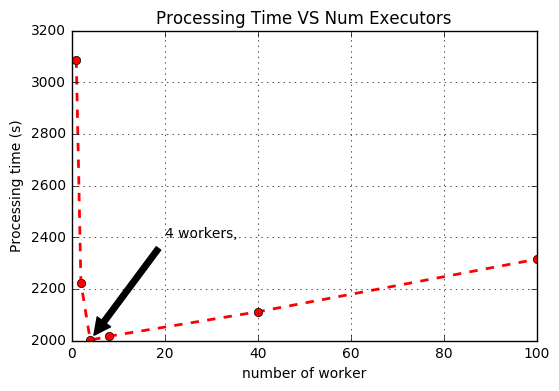

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(num_executor,run_time , lw=2, marker='o', linestyle='--', color='r', label='Square')

ax.annotate('4 workers, ', xy=(4, 2001), xytext=(20,2400),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )



plt.xlabel('number of worker')
plt.ylabel('Processing time (s)')
plt.title('Processing Time VS Num Executors')
plt.grid(True)


plt.show()

This graph is a little trick, let's look at the setup more closly.

Num Cores
1
Executor memory: 150 G.

2, 4, 8, 40, 80, 100]

In [4]:
data_raw = sc.textFile('/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Tweet_Output/Sample_Eng/,/mnt/381c2633-4d72-4555-9be8-19e922cce4a1/input/,/mnt/4e8ba653-f2f0-4e18-a51e-458026833dee/input/,/mnt/73dc2fdb-c49c-484c-bef8-7a6fc6abbc70/input,/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/input,/mnt/b93e71ec-8ddf-4033-bd42-770c05bc68aa/input')
data = data_raw.map(lambda line: json.loads(line))
#sqlContext = SQLContext(sc)
## Define Dataframe schema.
schema = StructType([StructField('creat_time', DoubleType(), False),
                     StructField('from_id', IntegerType(), False),
                     StructField('from_user', StringType(), False),
                     StructField('hashtag', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('mention', StringType(), True),
                     StructField('term', StringType(), True),
                     StructField('tweet_id', StringType(), False)                     
                    ])
df = sqlContext.createDataFrame(data, schema)

term_tokenizer = Tokenizer(inputCol="term", outputCol="words")
term_remover = StopWordsRemover(inputCol=term_tokenizer.getOutputCol(), outputCol="filtered")
term_cv = CountVectorizer(inputCol=term_remover.getOutputCol(), outputCol="term_features", minTF= 200, minDF=1)
#term_pipeline = Pipeline(stages=[term_tokenizer, term_remover,term_cv])


hashtag_tokenizer = Tokenizer(inputCol="hashtag", outputCol="tags")
hashtag_cv = CountVectorizer(inputCol=hashtag_tokenizer.getOutputCol(), outputCol="hashtag_features", minTF = 250, minDF=1)
#hashtag_pipeline = Pipeline(stages=[hashtag_tokenizer,hashtag_cv])

mention_tokenizer = Tokenizer(inputCol="mention", outputCol="mentions")
mention_cv = CountVectorizer(inputCol=mention_tokenizer.getOutputCol(), outputCol="mention_features", minTF= 250, minDF=1)
#mention_pipeline = Pipeline(stages=[mention_tokenizer, mention_cv])

user_tokenizer = Tokenizer(inputCol="from_user", outputCol="users")
user_cv = CountVectorizer(inputCol=user_tokenizer.getOutputCol(), outputCol="user_features", minTF= 250, minDF=1)

loc_tokenizer = Tokenizer(inputCol="location", outputCol="locs")
loc_cv = CountVectorizer(inputCol=loc_tokenizer.getOutputCol(), outputCol="loc_features", minTF= 200, minDF=1)

pipeline = Pipeline(stages=[term_tokenizer,term_remover,term_cv,hashtag_tokenizer,hashtag_cv,mention_tokenizer, \
                            mention_cv,user_tokenizer, user_cv, loc_tokenizer, loc_cv])

loading = time.time()

model = pipeline.fit(df)
Train_X = model.transform(df)

sec = time.time() - loading
print(sec)


2022.22762799


# I/O distribution

In [22]:
run_time = [2001, 1991, 2022.22762799]
num_executor = [1, 4, 6]

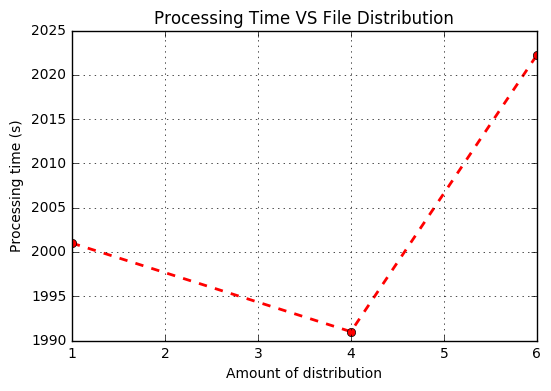

In [26]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(num_executor,run_time , lw=2, marker='o', linestyle='--', color='r', label='Square')


plt.xlabel('Amount of distribution')
plt.ylabel('Processing time (s)')
plt.title('Processing Time VS File Distribution')
plt.grid(True)


plt.show()

Distribute input file across different disks does not make a significant difference. I/O is not a major issue, given sufficient Ram.

<h2><strong>Reference</strong></h2>
<p>http://stackoverflow.com/questions/26562033/how-to-set-apache-spark-executor-memory<br />http://stackoverflow.com/questions/40012093/what-is-the-difference-between-spark-standalone-yarn-and-local-mode<br />https://jaceklaskowski.gitbooks.io/mastering-apache-spark/content/spark-local.html<br />http://data-scientist-in-training.blogspot.ca/2015/03/apache-spark-cluster-deployment-part-1.html<br />http://stackoverflow.com/questions/18394560/when-multiple-java-programs-run-on-the-same-machine<br />http://umashanthan.blogspot.ca/2016/03/what-difference-between-local.html<br />https://bzhangusc.wordpress.com/2015/06/10/why-your-join-is-so-slow/<br />http://alexanderwaldin.github.io/pyspark-quickstart-guide.html<br />http://kordinglab.com/2016/03/18/spark-script.html<br />http://stackoverflow.com/questions/24996302/setting-sparkcontext-for-pyspark</p>

In [6]:
run_time = [23666.322341918945, 12233.755597114563, 3154.57373213768, 2271.643699169159, 2021.8914141654968, 2025.3893520832062, 2010.4880039691925, 2022.0559360980988]
num_cores = [1, 2, 10, 20, 40, 100, 172, 500]